In [42]:
%matplotlib inline

In [43]:
# PUll in the libraries and define the functions we will be using

In [132]:
import os
import numpy as np
import matplotlib.pyplot as plt

def getChannelData(iChannel, strTestCase):
    cwd = os.getcwd()
    cwd = cwd+'\\TrainingData\\'+strTestCase

    f = []
    for (dirpath, dirnames, filenames) in os.walk(cwd):
        f.extend(filenames)
        break
        
    strFileSearch = 'Trace0' + str(iChannel)
    strFiles = filter(lambda x:strFileSearch in x, f)
    
    
    for idx in range(0, len(strFiles)):
        fh = open(cwd+'\\'+strFiles[idx], 'rb')
        # read the data into numpy
        if(idx==0):
            x = np.fromfile(fh, dtype=('>f'))
        else:
            x = np.append(x, np.fromfile(fh, dtype=('>f')))
        fh.close()
    
    return (x,strFiles)
    

In [133]:
# Begin by getting the data into python

['Trace01_0000000.dat']

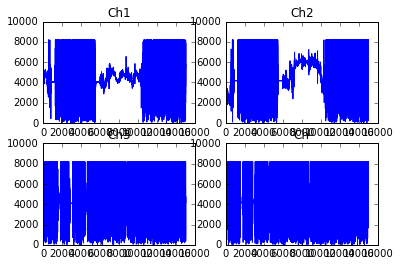

In [142]:
strFolder = 'CobblBattFail'
(x1,strFiles1) = getChannelData(1,strFolder)
(x2,strFiles2) = getChannelData(2,strFolder)
(x3,strFiles3) = getChannelData(3,strFolder)
(x4,strFiles4) = getChannelData(4,strFolder)
plt.subplot(2,2,1)
plt.plot(x1)
plt.ylim((0, 10000))
plt.title('Ch1')

plt.subplot(2,2,2)
plt.plot(x2)
plt.ylim((0, 10000))
plt.title('Ch2')

plt.subplot(2,2,3)
plt.plot(x3)
plt.ylim((0, 10000))
plt.title('Ch3')

plt.subplot(2,2,4)
plt.plot(x4)
plt.ylim((0, 10000))
plt.title('Ch')


strFiles1

In [136]:
x1

array([ 4078.,  4081.,  4086., ...,  3791.,  3862.,  3953.], dtype=float32)

In [137]:
x2

array([ 4175.,  4181.,  4180., ...,  4252.,  4129.,  4466.], dtype=float32)

In [138]:
x3

array([ 2244.,  2247.,  2246., ...,  2254.,  2516.,  2358.], dtype=float32)

In [139]:
x4

array([ 4306.,  4307.,  4307., ...,  4347.,  4343.,  4340.], dtype=float32)

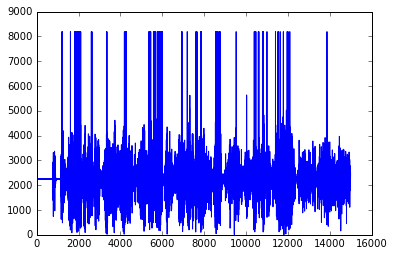

In [140]:
plt.plot(x3)

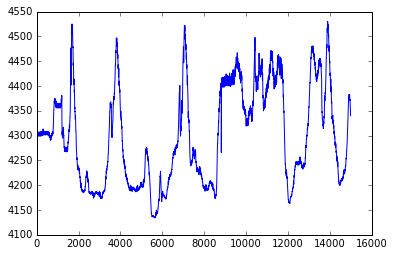

In [141]:
plt.plot(x4)